# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [212]:
# !pip install pycrf
# !pip install sklearn-crfsuite

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
import re
from collections import Counter
import itertools

model = spacy.load("en_core_web_sm")

##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

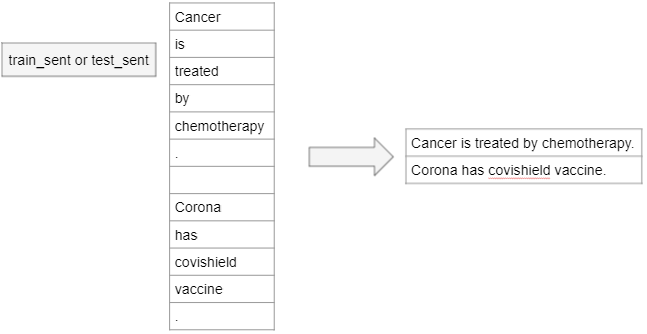

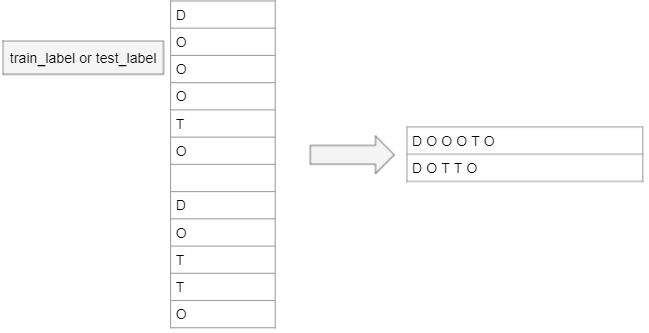

In [213]:
def get_file_content(file):
  file = open(file,"r")
  content = file.read()
  file.close()
  return content


In [214]:
train_sent = [ sentence.replace("\n"," ").split() for sentence in re.split(r"\n[ \t]*\n",get_file_content("train_sent")) if sentence]
train_label = [ labels.replace("\n"," ").split() for labels in re.split(r"\n[ \t]*\n",get_file_content("train_label")) if labels]
test_sent = [ sentence.replace("\n"," ").split() for sentence in re.split(r"\n[ \t]*\n",get_file_content("test_sent")) if sentence]
test_label = [ labels.replace("\n"," ").split() for labels in re.split(r"\n[ \t]*\n",get_file_content("test_label")) if labels]

### Count the number of sentences in the processed train and test dataset 

In [215]:
print(f"Number of Sentences in train dataset: {len(train_sent)}")
print(f"Number of Sentences in test dataset: {len(test_sent)}")

Number of Sentences in train dataset: 2599
Number of Sentences in test dataset: 1056


### Count the number of lines of labels in the processed train and test dataset.

In [216]:
print(f"Number of lines of labels in train dataset: {len(train_label)}")
print(f"Number of lines of labels in test dataset: {len(test_label)}")

Number of lines of labels in train dataset: 2599
Number of lines of labels in test dataset: 1056


In [217]:
## print first 5 sentences
for i in range(5):
  print(' '.join([ sentence_words for sentence_words in train_sent[i]]))

All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )
Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )
The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )
Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )


In [218]:
## print few sentence words with lables
train_sentences_labels=[]
train_words_labels=[]
test_sentences_labels=[]
test_words_labels=[]
for i in range(len(train_sent)):
  train_sentences_labels.append(list(zip(train_sent[i],train_label[i])))
  train_words_labels.extend(list(zip(train_sent[i],train_label[i])))
for i in range(len(test_sent)):
  test_sentences_labels.append(list(zip(test_sent[i],test_label[i])))
  test_words_labels.extend(list(zip(test_sent[i],test_label[i])))  
train_sentences_labels[0:6]


[[('All', 'O'),
  ('live', 'O'),
  ('births', 'O'),
  ('>', 'O'),
  ('or', 'O'),
  ('=', 'O'),
  ('23', 'O'),
  ('weeks', 'O'),
  ('at', 'O'),
  ('the', 'O'),
  ('University', 'O'),
  ('of', 'O'),
  ('Vermont', 'O'),
  ('in', 'O'),
  ('1995', 'O'),
  ('(', 'O'),
  ('n', 'O'),
  ('=', 'O'),
  ('2395', 'O'),
  (')', 'O'),
  ('were', 'O'),
  ('retrospectively', 'O'),
  ('analyzed', 'O'),
  ('for', 'O'),
  ('delivery', 'O'),
  ('route', 'O'),
  (',', 'O'),
  ('indication', 'O'),
  ('for', 'O'),
  ('cesarean', 'O'),
  (',', 'O'),
  ('gestational', 'O'),
  ('age', 'O'),
  (',', 'O'),
  ('parity', 'O'),
  (',', 'O'),
  ('and', 'O'),
  ('practice', 'O'),
  ('group', 'O'),
  ('(', 'O'),
  ('to', 'O'),
  ('reflect', 'O'),
  ('risk', 'O'),
  ('status', 'O'),
  (')', 'O')],
 [('The', 'O'),
  ('total', 'O'),
  ('cesarean', 'O'),
  ('rate', 'O'),
  ('was', 'O'),
  ('14.4', 'O'),
  ('%', 'O'),
  ('(', 'O'),
  ('344', 'O'),
  ('of', 'O'),
  ('2395', 'O'),
  (')', 'O'),
  (',', 'O'),
  ('and', 'O'),
  

In [219]:
## Print deceases and treatments 
deceases = filter(lambda x: x[1]=='D', train_words_labels)
treatments = filter(lambda x: x[1]=='T', train_words_labels)
print(set(deceases))
print(set(treatments))

{('multilocularis', 'D'), ('serovar', 'D'), ('damaged', 'D'), ('rectal', 'D'), ('Pneumococcal', 'D'), ('postoperative', 'D'), ('spontaneous', 'D'), ('postinfarction', 'D'), ('microalbuminuria', 'D'), ('hemodynamic', 'D'), ('stenoses', 'D'), ('tract', 'D'), ('diagnosed', 'D'), ('enteropathy', 'D'), ('bipolar', 'D'), ('stridor', 'D'), ('pre-eclampsia', 'D'), ('psychosis', 'D'), ('transfer', 'D'), ('purpura', 'D'), ('hominis', 'D'), ('Human', 'D'), ('A-induced', 'D'), ('throats', 'D'), ('hyperammonemia', 'D'), ('damage', 'D'), ('infections', 'D'), ('corpus', 'D'), ('anorectal', 'D'), ('granulomatosis', 'D'), ('sudden', 'D'), ('meningococcaemia', 'D'), ('cholangiocarcinoma', 'D'), ('events', 'D'), ('radiation-induced', 'D'), ('CML', 'D'), ('steroid-refractory', 'D'), ('Reflex', 'D'), ('heart', 'D'), ('balding', 'D'), ('multifocal', 'D'), ('mesodermal', 'D'), ('acidosis', 'D'), ('bacteremic', 'D'), ('A', 'D'), ('reactivated', 'D'), ('Nonimmune', 'D'), ('ophthalmoplegia', 'D'), ('LV', 'D'), 

##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [220]:
nouns_propns=[]
for sentence_words in (train_sent+test_sent):
  sentence = model(' '.join(sentence_words))
  nouns_propns.extend([token.text for token in sentence if token.pos_ in ['NOUN','PROPN']])



In [221]:
nouns_propns_count = Counter(nouns_propns)

In [222]:
print(nouns_propns_count)

Counter({'patients': 492, 'treatment': 281, '%': 247, 'cancer': 200, 'therapy': 175, 'study': 154, 'disease': 142, 'cell': 140, 'lung': 116, 'group': 94, 'chemotherapy': 88, 'gene': 87, 'effects': 85, 'women': 77, 'results': 77, 'use': 75, 'risk': 71, 'cases': 71, 'surgery': 71, 'analysis': 70, 'rate': 67, 'dose': 66, 'response': 66, 'survival': 65, 'children': 64, 'effect': 63, 'cells': 61, 'protein': 59, 'years': 58, 'combination': 58, 'patient': 58, 'syndrome': 57, 'term': 57, 'TO_SEE': 57, 'age': 56, 'care': 56, 'data': 55, 'studies': 53, 'activity': 53, 'control': 51, 'carcinoma': 51, 'health': 51, 'case': 50, 'mg': 50, 'evidence': 49, 'diagnosis': 48, 'management': 48, 'trial': 48, 'P': 47, 'year': 46, 'bone': 46, 'infection': 46, '#': 46, 'B': 45, 'stage': 44, 'C': 44, 'time': 42, 'role': 41, 'heart': 41, 'months': 41, 'trials': 41, 'blood': 41, 'growth': 40, 'failure': 40, 'tumor': 39, 'weeks': 37, 'CONCLUSIONS': 37, 'pregnancy': 37, 'hepatitis': 37, 'medicine': 36, 'day': 36, 

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [223]:
print(nouns_propns_count.most_common(25))

[('patients', 492), ('treatment', 281), ('%', 247), ('cancer', 200), ('therapy', 175), ('study', 154), ('disease', 142), ('cell', 140), ('lung', 116), ('group', 94), ('chemotherapy', 88), ('gene', 87), ('effects', 85), ('women', 77), ('results', 77), ('use', 75), ('risk', 71), ('cases', 71), ('surgery', 71), ('analysis', 70), ('rate', 67), ('dose', 66), ('response', 66), ('survival', 65), ('children', 64)]


## Defining features for CRF





In [224]:
# update pos tags for train and test sentences
for sentence_num, sentence_words in enumerate(train_sent):
  sentence = model(' '.join(sentence_words))
  pos=0
  tokentext=''
  for token in sentence:
    tokentext+=token.text
    # print("token:", token.text, tokentext, train_sentences_labels[num][pos][0])
    if tokentext == train_sentences_labels[sentence_num][pos][0]:
      train_sentences_labels[sentence_num][pos] = (train_sentences_labels[sentence_num][pos][0], train_sentences_labels[sentence_num][pos][1], token.pos_)
      pos+=1
      tokentext=''

for sentence_num, sentence_words in enumerate(test_sent):
  sentence = model(' '.join(sentence_words))
  pos=0
  tokentext=''
  for token in sentence:
    tokentext+=token.text
    # print("token:", token.text, tokentext, train_sentences_labels[num][pos][0])
    if tokentext == test_sentences_labels[sentence_num][pos][0]:
      test_sentences_labels[sentence_num][pos] = (test_sentences_labels[sentence_num][pos][0], test_sentences_labels[sentence_num][pos][1], token.pos_)
      pos+=1
      tokentext=''

In [225]:
## Let's print few sentences
print(train_sentences_labels[0:2])
print(test_sentences_labels[0:2])

[[('All', 'O', 'DET'), ('live', 'O', 'ADJ'), ('births', 'O', 'NOUN'), ('>', 'O', 'X'), ('or', 'O', 'CCONJ'), ('=', 'O', 'SYM'), ('23', 'O', 'NUM'), ('weeks', 'O', 'NOUN'), ('at', 'O', 'ADP'), ('the', 'O', 'DET'), ('University', 'O', 'PROPN'), ('of', 'O', 'ADP'), ('Vermont', 'O', 'PROPN'), ('in', 'O', 'ADP'), ('1995', 'O', 'NUM'), ('(', 'O', 'PUNCT'), ('n', 'O', 'ADP'), ('=', 'O', 'X'), ('2395', 'O', 'NUM'), (')', 'O', 'PUNCT'), ('were', 'O', 'AUX'), ('retrospectively', 'O', 'ADV'), ('analyzed', 'O', 'VERB'), ('for', 'O', 'ADP'), ('delivery', 'O', 'NOUN'), ('route', 'O', 'NOUN'), (',', 'O', 'PUNCT'), ('indication', 'O', 'NOUN'), ('for', 'O', 'ADP'), ('cesarean', 'O', 'PROPN'), (',', 'O', 'PUNCT'), ('gestational', 'O', 'ADJ'), ('age', 'O', 'NOUN'), (',', 'O', 'PUNCT'), ('parity', 'O', 'NOUN'), (',', 'O', 'PUNCT'), ('and', 'O', 'CCONJ'), ('practice', 'O', 'NOUN'), ('group', 'O', 'NOUN'), ('(', 'O', 'PUNCT'), ('to', 'O', 'PART'), ('reflect', 'O', 'VERB'), ('risk', 'O', 'NOUN'), ('status', 

In [226]:
# Let's define the features to get the feature value for one word.
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][2]
    
    features = {
        'bias': 1.0, 
        'word.lower()': word.lower(), 
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True
    return features





## Getting the features

### Write a code/function to get the features for a sentence

In [227]:
# Write a code to get features for a sentence.

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]


### Write a code/function to get the labels of a sentence

In [228]:
# Write a code to get the labels for a sentence.
def sent2labels(sent):
    return [label for token, label, postag in sent]

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [229]:
train_features = [sent2features(sentence) for sentence in train_sentences_labels]
test_features = [sent2features(sentence) for sentence in test_sentences_labels]

In [230]:
train_features[0]

[{'bias': 1.0,
  'word.lower()': 'all',
  'word[-3:]': 'All',
  'word[-2:]': 'll',
  'word.isupper()': False,
  'word.istitle()': True,
  'word.isdigit()': False,
  'postag': 'DET',
  'postag[:2]': 'DE',
  'BOS': True,
  '+1:word.lower()': 'live',
  '+1:word.istitle()': False,
  '+1:word.isupper()': False,
  '+1:postag': 'O',
  '+1:postag[:2]': 'O'},
 {'bias': 1.0,
  'word.lower()': 'live',
  'word[-3:]': 'ive',
  'word[-2:]': 've',
  'word.isupper()': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  'postag': 'ADJ',
  'postag[:2]': 'AD',
  '-1:word.lower()': 'all',
  '-1:word.istitle()': True,
  '-1:word.isupper()': False,
  '-1:postag': 'O',
  '-1:postag[:2]': 'O',
  '+1:word.lower()': 'births',
  '+1:word.istitle()': False,
  '+1:word.isupper()': False,
  '+1:postag': 'O',
  '+1:postag[:2]': 'O'},
 {'bias': 1.0,
  'word.lower()': 'births',
  'word[-3:]': 'ths',
  'word[-2:]': 'hs',
  'word.isupper()': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  'post

### Define the labels as the target variable for test and the train dataset

In [231]:
train_labels = [sent2labels(sentence) for sentence in train_sentences_labels]
test_labels = [sent2labels(sentence) for sentence in test_sentences_labels]

## Build the CRF Model

In [232]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',### l2sgd
    c1 = 0.1,
    c2 = 0.1,
    max_iterations = 100,
    all_possible_transitions=True)
try:
  crf.fit(train_features, train_labels)
except:
  pass


## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [233]:
test_pred = crf.predict(test_features)


### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [234]:
metrics.flat_f1_score(test_labels, test_pred, average='weighted')

0.982575892544266



*   An f1-score of  98% is good one and We can proceed with this CRF model.

In [235]:
print("Recall:", metrics.flat_recall_score(test_labels,test_pred,average='weighted'))
print("Precision:", metrics.flat_precision_score(test_labels,test_pred,average='weighted'))
print("Accuracy:", metrics.flat_accuracy_score(test_labels,test_pred))

Recall: 0.9826511977656032
Precision: 0.9825326967543142
Accuracy: 0.9826511977656032


In [236]:
# Example test sentence and corresponding actual and predicted labels 
sen_num=887
print("Sentence: ",test_sent[sen_num])
print("Actual labels:    ", test_labels[sen_num])
print("Predicted labels: ", test_pred[sen_num])

Sentence:  ['<', 'TO_SEE', '>', 'in', 'another', 'randomised', 'phase', 'iii', 'trial', 'in', '303', 'patients', 'with', 'head', 'and', 'neck', 'cancer', 'undergoing', 'irradiation', 'therapy', '(', 'total', 'dose', '50', 'to', '70gy', ')', ',', 'pretreatment', 'with', 'intravenous', 'amifostine', '200', 'mg/m2', 'significantly', 'reduced', 'the', 'incidence', 'of', 'acute', 'and', 'late', 'grade', '>', 'or', '=2', 'xerostomia']
Actual labels:     ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D', 'D', 'D', 'D', 'O', 'T', 'T', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'T', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D']
Predicted labels:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D', 'D', 'D', 'D', 'O', 'T', 'T', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'T', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D']


##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

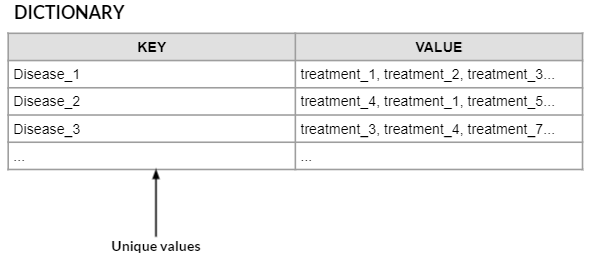

In [237]:
## create a dictionary of diseases and treatment for each sentence in test dataset
disease_treatment={}
for test_sent_num, test_sent_labels in enumerate(test_pred):
  labels = ''.join(test_sent_labels)
  disecases=[]
  treatments=[]
  for diecease_pos in re.finditer('D+',labels): # find the disease lables positions (start, end) and get corresponding words using the positions
    disecases.append(' '.join([word_labels[0] for word_labels in test_sentences_labels[test_sent_num][diecease_pos.start():diecease_pos.end()]]))
  for treatment_pos in re.finditer('T+',labels):  # find the treatment lables positions (start, end) and get corresponding words using the positions
    treatments.append(' '.join([word_labels[0] for word_labels in test_sentences_labels[test_sent_num][treatment_pos.start():treatment_pos.end()]]))
  
  # loop through disceases present in the sentence and create/update dictionary
  for disease in disecases:
    if disease in disease_treatment.keys():
      # if disease is already present in dictionary extend the treatment
      disease_treatment[disease].extend(treatments)
    else:
      # Creating list of treatments for particular disease if it doesn not exist already.
      disease_treatment[disease] = treatments


In [238]:
# Print all disceases and treatments from test dataset
{ disease:treatment for disease, treatment in disease_treatment.items() if treatment!=[]}

{'preeclampsia': ['partner insemination program',
  'donor insemination program'],
 'breast cancer': ['Hormone replacement therapy',
  'oxaliplatin',
  'undergone subcutaneous mastectomy'],
 'breast cancer diagnosis': ['Hormone replacement therapy',
  'oxaliplatin',
  'undergone subcutaneous mastectomy'],
 'ovarian cancer': ['Hormone replacement therapy',
  'oxaliplatin',
  'undergone subcutaneous mastectomy'],
 'retinoblastoma': ['radiotherapy'],
 'epilepsy': ['Methylphenidate'],
 'ADHD': ['Methylphenidate'],
 'myocardial infarction': ['mg aspirin ,',
  'mg warfarin with 80 mg aspirin',
  'mg warfarin with 80 mg aspirin'],
 'unstable angina or non-Q-wave myocardial infarction': ['roxithromycin'],
 'coronary-artery disease': ['Antichlamydial antibiotics'],
 'cerebral palsy': ['Hyperbaric oxygen therapy'],
 'infection': ['antileukemic therapy'],
 'primary pulmonary hypertension ( PPH )': ['fenfluramines'],
 'essential hypertension': ['moxonidine'],
 'cellulitis': ['G-CSF'],
 'foot infec

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [239]:
disease_search='hereditary retinoblastoma'#'mild preeclampsia'
treatments=''
if disease_search  in disease_treatment:
  treatments = ', '.join(disease_treatment[disease_search])
else:
  diseases = disease_search.split()
  for disease in diseases:
    if disease in disease_treatment:
      treatments += ', '.join(disease_treatment[disease])

print(f"Treatments for \033[1m{disease_search}\033[0m is/are \033[1m{ treatments}")

Treatments for hereditary retinoblastoma is/are radiotherapy
